# Queue daily and hyperparam optimization

In [11]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings

# To suppress all warnings
warnings.filterwarnings("ignore")

TODOS:

1. Count of ppl / unique macs
- settle on 1 uncertainty measure and formulate the arguments why

2. Queue model
- check model in each day
- error from serving speed flowing in or top-down in queue model?
- error in count of ppl: by uniform or something else?
- why are error bars that small?
- run queue model on arbitrary time step (1 min vs 5 mins vs other)

## Data preparation

In [12]:
df = pd.read_csv(r'C:/Users/mihai/Documents/Faculta/Data Literacy/Mensa Project/dataLiteracyPeopleCounting/data/Wed.csv', index_col=0)

In [13]:
df.head()

,frame.number,frame.time,wlan.sa,wlan.da,_ws.col.protocol,frame.len,wlan.ssid,date-time,hour:minute
0,1,"Jan 10, 2024 10:01 CET",00:f6:63:81:c8:6b,ff:ff:ff:ff:ff:ff,802.11,298,55546775657374,2024-01-10 10:01:00+01:00,11:01
2,3,"Jan 10, 2024 10:01 CET",50:ed:3c:13:d7:4d,00:f6:63:81:c8:6f,802.11,43,NaN,2024-01-10 10:01:00+01:00,11:01
4,5,"Jan 10, 2024 10:01 CET",00:f6:63:81:c8:6e,ff:ff:ff:ff:ff:ff,802.11,286,4775657374,2024-01-10 10:01:00+01:00,11:01
31,32,"Jan 10, 2024 10:01 CET",50:ed:3c:13:d7:4d,00:f6:63:81:c8:6f,802.11,43,NaN,2024-01-10 10:01:00+01:00,11:01
33,34,"Jan 10, 2024 10:01 CET",00:f6:63:81:c8:6f,ff:ff:ff:ff:ff:ff,802.11,336,656475726f616d,2024-01-10 10:01:00+01:00,11:01


In [14]:
# filter by ssid
df = df[df["wlan.ssid"] == "656475726f616d"] #eduroam

df_first = df.drop_duplicates(subset='wlan.sa', keep='first')
df_last = df.drop_duplicates(subset='wlan.sa', keep='last')

per_min_last=pd.DataFrame(df_last["hour:minute"].value_counts().sort_index())
per_min_new=pd.DataFrame(df_first["hour:minute"].value_counts().sort_index())

_5min_new = pd.DataFrame({'hour:minute':per_min_new.index.tolist(),'count': per_min_new["count"]})
_5min_new['hour:minute'] = pd.to_datetime(_5min_new['hour:minute'], format='%H:%M')
_5min_new['hour:minute'].dt.strftime('%H:%M')
_5min_new.set_index('hour:minute',inplace=True)
count_first_1min = _5min_new #.reset_index(drop=True, inplace=True)
_5min_new_ = _5min_new.resample('5T').sum()
#print(count_first_1min)
_5min_last = pd.DataFrame({'hour:minute':per_min_last.index.tolist(),'count': per_min_last["count"]})
_5min_last['hour:minute'] = pd.to_datetime(_5min_last['hour:minute'], format="%H:%M")
_5min_last.set_index('hour:minute', inplace=True)
last_per5min_ = _5min_last.resample('5T').sum()
#print(_5min_last.reset_index(drop=True, inplace=True))
count_last_1min = _5min_last
df_minute = df.groupby('hour:minute')['wlan.sa'].nunique()
s1 = count_first_1min[15:].stack()
s2 = df_minute[20:-1]
df_20 = pd.DataFrame({'enter_count':s1})
#df_20['enter_count'] = s2
df_20['total_count'] = s2.to_numpy()



## Computing number of people from unique macs using uniform distribution

In [15]:

def random_counts(enter_count):
   r = np.random.uniform(0, 1, enter_count)
   r_c = np.ones_like(r)
   r_c = np.where(r >= 0.85, np.where(r >= 0.90, 0, 2 ), 1)
   return r_c.sum()

df_20['enter_count_rand'] = df_20['enter_count'].apply(random_counts)

### Comparing priors

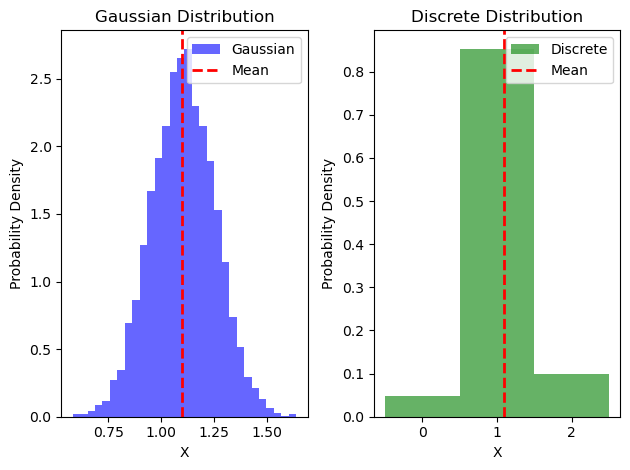

Probability(Gaussian = 0): 0.0000
Probability(Gaussian = 1): 2.1297
Probability(Gaussian > 2): 0.0000
Probability(Discrete = 0): 0.0500
Probability(Discrete = 1): 0.8500
Probability(Discrete > 2): 0.1000


In [16]:

# Parameters for both distributions
mean = 1.1
std_dev = 0.15

# Calculate the z-score for the threshold value 1
z_score_1 = (1 - mean) / std_dev

# Calculate the z-score for the threshold value 2
z_score_2 = (2 - mean) / std_dev

# Calculate the tail probabilities for the Gaussian distribution
prob_gaussian_lt_1 = norm.cdf(1, loc=mean, scale=std_dev)
prob_gaussian_geq_2 = 1 - norm.cdf(2, loc=mean, scale=std_dev)

# Define the desired tail probabilities for the discrete distribution
desired_prob_lt_1 = prob_gaussian_lt_1
desired_prob_geq_2 = prob_gaussian_geq_2

# Calculate the probability of X = 0 in the discrete distribution
prob_discrete_eq_0 = 0.05

# Calculate the remaining probability for X = 1 in the discrete distribution
remaining_prob_for_eq_1 = 1 - prob_discrete_eq_0

# Calculate the probability of X > 2 in the discrete distribution
prob_discrete_gt_2 = 0.1

# Calculate the probability of X = 1 in the discrete distribution
prob_discrete_eq_1 = remaining_prob_for_eq_1 - prob_discrete_gt_2

# Generate data for the Gaussian distribution
data_gaussian = np.random.normal(mean, std_dev, 10000)

# Generate data for the discrete distribution
data_discrete = np.random.choice([0, 1, 2], 10000, p=[prob_discrete_eq_0, prob_discrete_eq_1, prob_discrete_gt_2])

# Plot the Gaussian distribution
plt.subplot(1, 2, 1)
plt.hist(data_gaussian, bins=30, density=True, alpha=0.6, color='b', label='Gaussian')
plt.title('Gaussian Distribution')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label='Mean')
plt.legend()

# Plot the discrete distribution
plt.subplot(1, 2, 2)
plt.hist(data_discrete, bins=[-0.5, 0.5, 1.5, 2.5], density=True, alpha=0.6, color='g', label='Discrete')
plt.title('Discrete Distribution')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.xticks([0, 1, 2])
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label='Mean')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate the z-scores for the threshold values
z_score_0 = (0 - mean) / std_dev
z_score_1 = (1 - mean) / std_dev
z_score_2 = (2 - mean) / std_dev

# Calculate the PDFs for the Gaussian distribution at specific points
pdf_at_0 = norm.pdf(0, loc=mean, scale=std_dev)
pdf_at_1 = norm.pdf(1, loc=mean, scale=std_dev)
pdf_gt_2 = 1 - norm.cdf(2, loc=mean, scale=std_dev)

# Print the calculated probabilities for the Gaussian distribution
print(f'Probability(Gaussian = 0): {pdf_at_0:.4f}')
print(f'Probability(Gaussian = 1): {pdf_at_1:.4f}')
print(f'Probability(Gaussian > 2): {pdf_gt_2:.4f}')
# Print the calculated probabilities for the discrete distribution
print(f'Probability(Discrete = 0): {prob_discrete_eq_0:.4f}')
print(f'Probability(Discrete = 1): {prob_discrete_eq_1:.4f}')
print(f'Probability(Discrete > 2): {prob_discrete_gt_2:.4f}')

#### Q1 here: pick a uniform distribution for number of ppl / device or a gaussian/gamma?

## Naive queue model

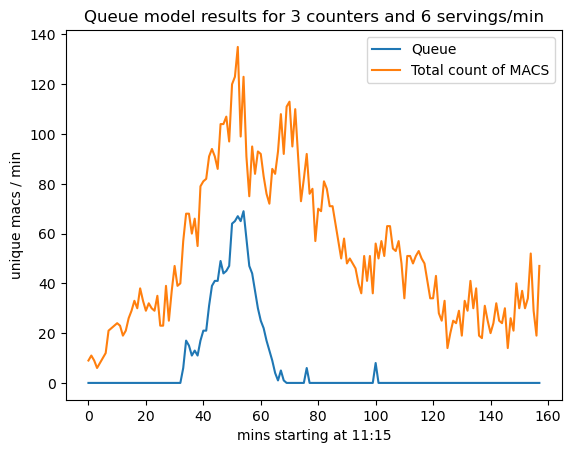

In [18]:
# Hyperparameters
nr_counters = 3
serving_speed = 6  # people per minute for one counter

# Initialize queue_count column
df_20['queue_count'] = 0

# Calculate queue count for each minute
for i in range(len(df_20)):
    #print(i)
    if i == 0: #timepoint 0
        df_20['queue_count'].iloc[i] = max(0, 0 + df_20['enter_count'].iloc[i] - nr_counters * serving_speed)
    else:
        df_20['queue_count'].iloc[i] = max(0, df_20['queue_count'].iloc[i-1] + df_20['enter_count'].iloc[i] - nr_counters * serving_speed)

    
#print(df_20)
plt.plot(df_20['queue_count'].to_numpy(), label='Queue')
plt.plot(range(total_minutes), df_20['total_count'], label='Total count')
plt.plot(range(total_minutes), df_20['enter_count'], label='First seen count')
plt.title(f'Queue model results for {nr_counters} counters and {serving_speed} servings/min')
plt.ylabel('unique macs / min')
plt.xlabel('mins starting at 11:15')
plt.legend()
# important: data starts at 11:15 (bcs at the start we have some minutes with no new entries


## Improved queue model without uncertainty

49

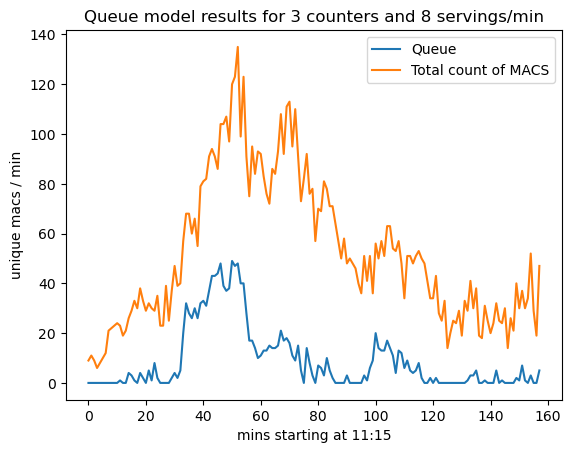

In [21]:
# Hyperparams
nr_counters = 3
serving_speed = 8  # people per minute for all coutners
max_serve_speed = 20

# Initialize queue_count column
df_20['queue_count'] = 0


# Calculate queue count for each minute
for i in range(len(df_20)):
    #print(i)
    if i == 0: #timepoint 0
        df_20['queue_count'].iloc[i] = max(0, 0 + df_20['enter_count_rand'].iloc[i] - serving_speed)
    else:
        serving_speed_estimation = min(max_serve_speed, serving_speed+(df_20['queue_count'].iloc[i-1]/nr_counters))
        df_20['queue_count'].iloc[i] = max(0, df_20['queue_count'].iloc[i-1] + df_20['enter_count_rand'].iloc[i] - np.round(serving_speed_estimation))

plt.plot(df_20['queue_count'].to_numpy(), label='Queue')
plt.plot(range(total_minutes), df_20['total_count'], label='Total count')
plt.plot(range(total_minutes), df_20['enter_count'], label='First seen count')
plt.title(f'Queue model results for {nr_counters} counters and {serving_speed} servings/min')
plt.ylabel('unique macs / min')
plt.xlabel('mins starting at 11:15')
plt.legend()
# important: data starts at 11:15 (bcs at the start we have some minutes with no new entries

max(df_20['queue_count'])

## Naive queue model with uncertainty only from serving speed

General idea: 

Make serving speed vary with N(5,1) for one counter for each minute
Simulate 1000 queues and calculate mean and sd, then calculate SE from sd/np.sqrt(len(df)) and build confidence intervals

Q2: how to calculate SE? is it correct right now?

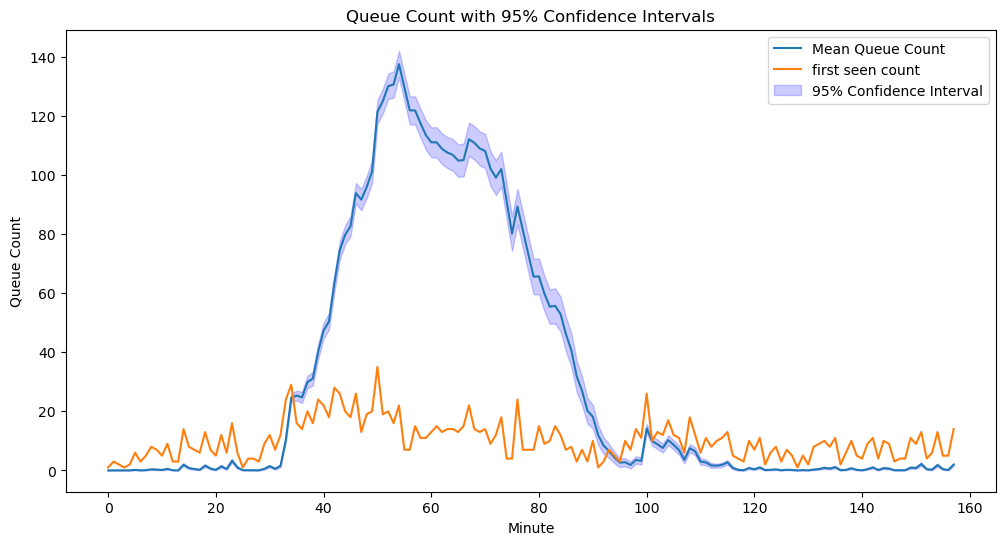

In [23]:

# Hyperparams
mean_serving_speed = 5 # for 1 counter
std_dev_serving_speed = 2
nr_counters = 3
total_minutes = len(df_20) # for simulation
num_simulations = 1000 # for bootstrapping and obtaining uncertainty estimate
df = df_20

# Function to run a single simulation
check_ppl_served = [] #used to check the values afterwards

def run_simulation():
    #df = pd.DataFrame({'minute': range(total_minutes), 'people_estimate': np.random.randint(1, 10, total_minutes)})
    df['queue_count'] = 0
    for i in range(1, len(df)):
        serving_speed = np.random.normal(mean_serving_speed, std_dev_serving_speed)
        serving_speed = max(serving_speed, 0)
        people_served = nr_counters * serving_speed
        check_ppl_served.append(people_served)
        df['queue_count'].iloc[i] = max(0, df['queue_count'].iloc[i - 1] + df['enter_count'].iloc[i] - people_served)
    return df['queue_count']

# Run multiple simulations
all_simulations = np.array([run_simulation() for _ in range(num_simulations)])

# Calculate mean and standard error at each minute
mean_queue_counts = all_simulations.mean(axis=0)
stderr_queue_counts = all_simulations.std(axis=0) / np.sqrt(len(df))

# Calculate 95% confidence intervals
ci_lower = mean_queue_counts - 1.96 * stderr_queue_counts
ci_upper = mean_queue_counts + 1.96 * stderr_queue_counts

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(total_minutes), mean_queue_counts, label='Mean Queue Count')
plt.plot(range(total_minutes), df_20['total_count'], label='Total count')
plt.plot(range(total_minutes), df_20['enter_count'], label='First seen count')

plt.fill_between(range(total_minutes), ci_lower, ci_upper, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Minute')
plt.ylabel('Queue Count')
plt.title('Queue Count with 95% Confidence Intervals')
plt.legend()
plt.show()


## Naive queue model with uncertainty from serving speed AND uncertain number of people

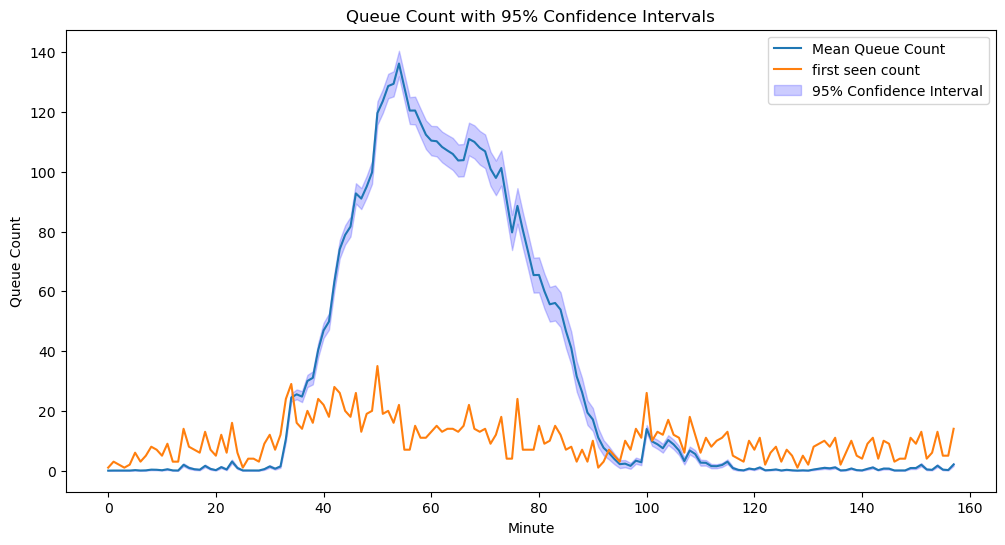

In [25]:

# Constants
mean_serving_speed = 5
std_dev_serving_speed = 2
nr_counters = 3
total_minutes = len(df_20)
num_simulations = 1000
df = df_20
# Function to run a single simulation
check_ppl_served = []
def run_simulation():
    #df = pd.DataFrame({'minute': range(total_minutes), 'people_estimate': np.random.randint(1, 10, total_minutes)})
    df['queue_count'] = 0
    for i in range(1, len(df)):
        
        df_20['enter_count_rand'] = df_20['enter_count'].apply(random_counts) # estimate a different nr ppl / device in each go

        serving_speed = np.random.normal(mean_serving_speed, std_dev_serving_speed)
        serving_speed = max(serving_speed, 0)
        people_served = nr_counters * serving_speed
        check_ppl_served.append(people_served)
        df['queue_count'].iloc[i] = max(0, df['queue_count'].iloc[i - 1] + df['enter_count'].iloc[i] - people_served)
    return df['queue_count']

# Run multiple simulations
all_simulations = np.array([run_simulation() for _ in range(num_simulations)])

# Calculate mean and standard error at each minute
mean_queue_counts = all_simulations.mean(axis=0)
stderr_queue_counts = all_simulations.std(axis=0) / np.sqrt(len(df))

# Calculate 95% confidence intervals
ci_lower = mean_queue_counts - 1.96 * stderr_queue_counts
ci_upper = mean_queue_counts + 1.96 * stderr_queue_counts

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(total_minutes), mean_queue_counts, label='Mean Queue Count')
plt.plot(range(total_minutes), df_20['enter_count'], label='first seen count')
plt.fill_between(range(total_minutes), ci_lower, ci_upper, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Minute')
plt.ylabel('Queue Count')
plt.title('Queue Count with 95% Confidence Intervals')
plt.legend()
plt.show()


## Improved queue with uncertainty from people count

Q3: decide how to combine serving speed estimate with our min 8, max 20 servings

In [ ]:
# Hyperparams
nr_counters = 3

# restrictions
serving_speed = 8  # people per minute
max_serve_speed = 20

# Initialize queue_count column
df_20['queue_count'] = 0

def run_simulation():
    #df = pd.DataFrame({'minute': range(total_minutes), 'people_estimate': np.random.randint(1, 10, total_minutes)})
    df['queue_count'] = 0
    for i in range(1, len(df)):

        # random count of people
        df_20['enter_count_rand'] = df_20['enter_count'].apply(random_counts) # estimate a different nr ppl / device in each go

        if i == 0: #timepoint 0
            df_20['queue_count'].iloc[i] = max(0, 0 + df_20['enter_count_rand'].iloc[i] - serving_speed)
        else:
            serving_speed_estimation = min(max_serve_speed, serving_speed+(df_20['queue_count'].iloc[i-1]/nr_counters))
            df_20['queue_count'].iloc[i] = max(0, df_20['queue_count'].iloc[i-1] + df_20['enter_count_rand'].iloc[i] - np.round(serving_speed_estimation))

    return df['queue_count']


# Run multiple simulations
all_simulations = np.array([run_simulation() for _ in range(num_simulations)])

# Calculate mean and standard error at each minute
mean_queue_counts = all_simulations.mean(axis=0)
stderr_queue_counts = all_simulations.std(axis=0) / np.sqrt(len(df))

# Calculate 95% confidence intervals
ci_lower = mean_queue_counts - 1.96 * stderr_queue_counts
ci_upper = mean_queue_counts + 1.96 * stderr_queue_counts

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(total_minutes), mean_queue_counts, label='Mean Queue Count')
plt.plot(range(total_minutes), df_20['enter_count'], label='first seen count')
plt.fill_between(range(total_minutes), ci_lower, ci_upper, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Minute')
plt.ylabel('Queue Count')
plt.title('Queue Count with 95% Confidence Intervals')
plt.legend()
plt.show()

## Improved queue model with uncertainty from serving speed 

In [ ]:
# Hyperparams
nr_counters = 3
mean_serving_speed = 5
std_dev_serving_speed = 2

# restrictions
serving_speed = 8  # people per minute
max_serve_speed = 20

# Initialize queue_count column
df_20['queue_count'] = 0

def run_simulation():
    #df = pd.DataFrame({'minute': range(total_minutes), 'people_estimate': np.random.randint(1, 10, total_minutes)})
    df['queue_count'] = 0
    for i in range(1, len(df)):
        
        # random serving speed
        serving_speed = np.random.normal(mean_serving_speed, std_dev_serving_speed)
        serving_speed = max(serving_speed, 0)
        
        if i == 0: #timepoint 0
            df_20['queue_count'].iloc[i] = max(0, 0 + df_20['enter_count_rand'].iloc[i] - serving_speed)
        else:
            serving_speed_estimation = min(max_serve_speed, serving_speed+(df_20['queue_count'].iloc[i-1]/nr_counters))
            df_20['queue_count'].iloc[i] = max(0, df_20['queue_count'].iloc[i-1] + df_20['enter_count_rand'].iloc[i] - np.round(serving_speed_estimation))

    return df['queue_count']


# Run multiple simulations
all_simulations = np.array([run_simulation() for _ in range(num_simulations)])

# Calculate mean and standard error at each minute
mean_queue_counts = all_simulations.mean(axis=0)
stderr_queue_counts = all_simulations.std(axis=0) / np.sqrt(len(df))

# Calculate 95% confidence intervals
ci_lower = mean_queue_counts - 1.96 * stderr_queue_counts
ci_upper = mean_queue_counts + 1.96 * stderr_queue_counts

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(total_minutes), mean_queue_counts, label='Mean Queue Count')
plt.plot(range(total_minutes), df_20['enter_count'], label='first seen count')
plt.fill_between(range(total_minutes), ci_lower, ci_upper, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Minute')
plt.ylabel('Queue Count')
plt.title('Queue Count with 95% Confidence Intervals')
plt.legend()
plt.show()

## Improved queue model with uncertainty from serving speed AND people count

In [ ]:
# Hyperparams
nr_counters = 3
mean_serving_speed = 5
std_dev_serving_speed = 2

# restrictions
serving_speed = 8  # people per minute
max_serve_speed = 20

# Initialize queue_count column
df_20['queue_count'] = 0

def run_simulation():
    #df = pd.DataFrame({'minute': range(total_minutes), 'people_estimate': np.random.randint(1, 10, total_minutes)})
    df['queue_count'] = 0
    for i in range(1, len(df)):

        # random count of people
        df_20['enter_count_rand'] = df_20['enter_count'].apply(random_counts) # estimate a different nr ppl / device in each go

        # random serving speed
        serving_speed = np.random.normal(mean_serving_speed, std_dev_serving_speed)
        serving_speed = max(serving_speed, 0)
        
        if i == 0: #timepoint 0
            df_20['queue_count'].iloc[i] = max(0, 0 + df_20['enter_count_rand'].iloc[i] - serving_speed)
        else:
            serving_speed_estimation = min(max_serve_speed, serving_speed+(df_20['queue_count'].iloc[i-1]/nr_counters))
            df_20['queue_count'].iloc[i] = max(0, df_20['queue_count'].iloc[i-1] + df_20['enter_count_rand'].iloc[i] - np.round(serving_speed_estimation))

    return df['queue_count']


# Run multiple simulations
all_simulations = np.array([run_simulation() for _ in range(num_simulations)])

# Calculate mean and standard error at each minute
mean_queue_counts = all_simulations.mean(axis=0)
stderr_queue_counts = all_simulations.std(axis=0) / np.sqrt(len(df))

# Calculate 95% confidence intervals
ci_lower = mean_queue_counts - 1.96 * stderr_queue_counts
ci_upper = mean_queue_counts + 1.96 * stderr_queue_counts

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(total_minutes), mean_queue_counts, label='Mean Queue Count')
plt.plot(range(total_minutes), df_20['enter_count'], label='first seen count')
plt.fill_between(range(total_minutes), ci_lower, ci_upper, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Minute')
plt.ylabel('Queue Count')
plt.title('Queue Count with 95% Confidence Intervals')
plt.legend()
plt.show()

## Improved queue model with uncertainty from global queue hyperparameter

In [ ]:
#TODO